In [ ]:
import csv
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import re

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

# Load the YouTube comments CSV
df = pd.read_csv('comments.csv')

# Function to clean and preprocess each comment
def preprocess_comment(text):
    text = str(text).lower()                        # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", '', text)         # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing
df['Cleaned_Comment'] = df['Comment'].apply(preprocess_comment)

# Apply sentiment analysis
def analyze_sentiment(comment):
    scores = sia.polarity_scores(comment)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['Cleaned_Comment'].apply(analyze_sentiment)

# Save the results
df.to_csv('comments_with_sentiment.csv', index=False)

print("Sentiment analysis completed. Results saved to 'comments_with_sentiment.csv'.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Sentiment analysis completed. Results saved to 'comments_with_sentiment.csv'.


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from tqdm import tqdm

# Load your dataset
df = pd.read_csv("comments.csv")

# Drop empty/missing comments
df = df.dropna(subset=['Comment'])
df = df[df['Comment'].str.strip() != '']

# Use a pre-trained BERT sentiment model
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Create pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Clean up text (optional)
def clean_text(text):
    text = str(text).lower()
    text = text.replace('\n', ' ').replace('\r', '')
    return text.strip()

df['Cleaned_Comment'] = df['Comment'].apply(clean_text)

# Apply the sentiment model
def classify_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]  # Truncate long comments for BERT
        return result['label']
    except Exception as e:
        return 'error'

# Progress bar for processing
tqdm.pandas(desc="Classifying Sentiment")
df['Sentiment'] = df['Cleaned_Comment'].progress_apply(classify_sentiment)

# Normalize label names
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive',
    'NEGATIVE': 'negative',
    'NEUTRAL': 'neutral',
    'POSITIVE': 'positive'
}
df['Sentiment'] = df['Sentiment'].map(label_map).fillna(df['Sentiment'])

# Save the new file
df.to_csv("comments_with_bert_sentiment.csv", index=False)
print("✅ Sentiment analysis complete. Results saved to 'comments_with_bert_sentiment.csv'.")

Device set to use cpu
Classifying Sentiment: 100%|██████████| 79990/79990 [3:30:28<00:00,  6.33it/s]


✅ Sentiment analysis complete. Results saved to 'comments_with_bert_sentiment.csv'.


In [ ]:
!pip install gensim pyLDAvis nltk wordcloud seaborn transformers

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipython-input-8-2742261419.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')


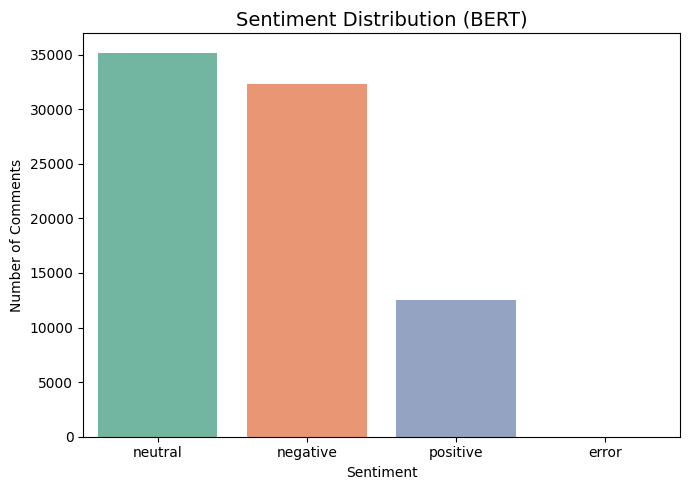

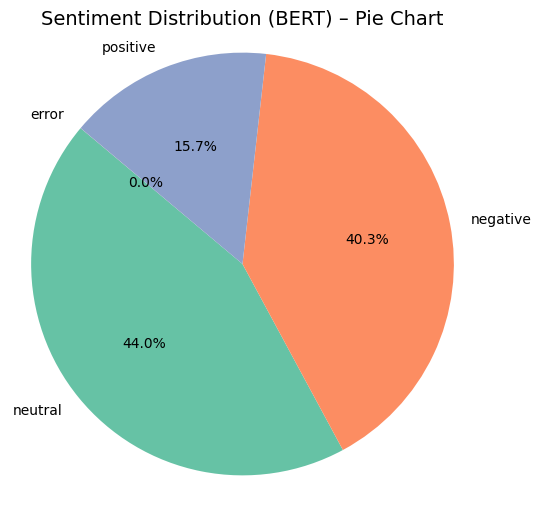

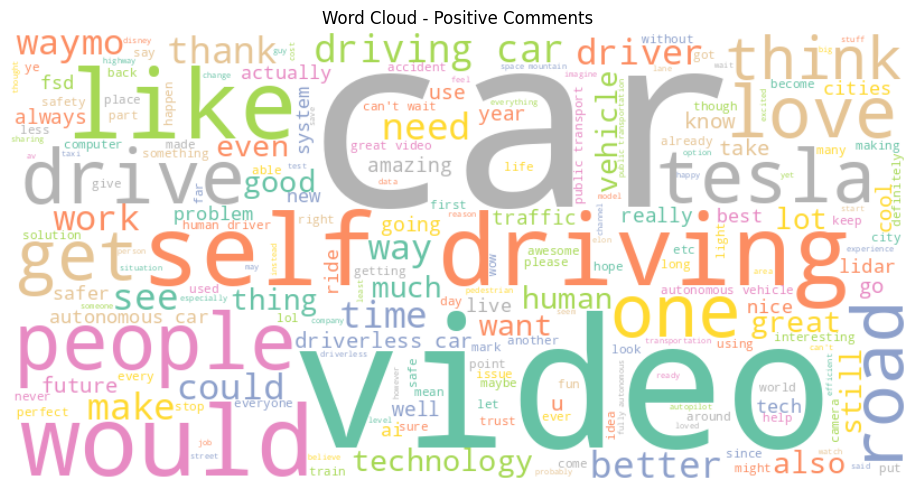

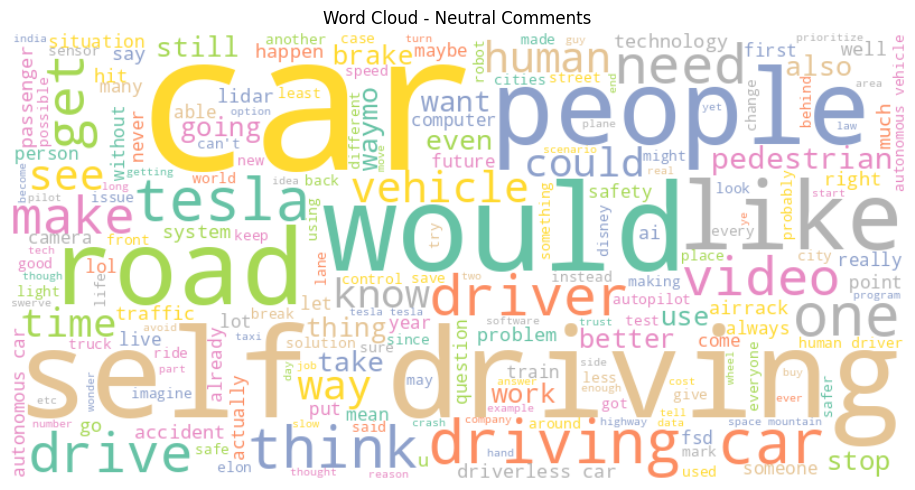

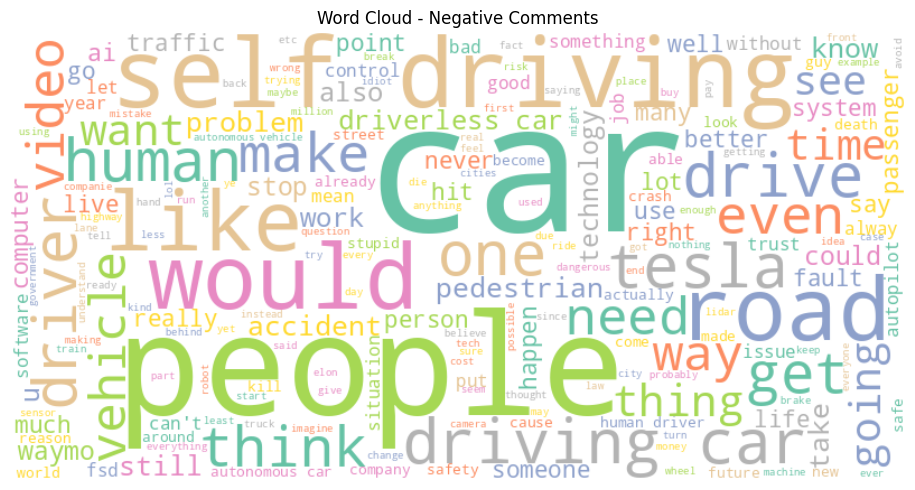


Top Keywords per Topic:
Topic 1: 0.024*"would" + 0.019*"driver" + 0.016*"human" + 0.016*"vehicle" + 0.015*"people" + 0.014*"make"
Topic 2: 0.157*"car" + 0.052*"driving" + 0.034*"road" + 0.026*"self" + 0.024*"drive" + 0.024*"driverless"
Topic 3: 0.044*"get" + 0.029*"want" + 0.026*"people" + 0.023*"company" + 0.017*"u" + 0.015*"lot"
Topic 4: 0.028*"na" + 0.022*"gon" + 0.012*"waiting" + 0.012*"steering" + 0.010*"pull" + 0.009*"bug"
Topic 5: 0.035*"like" + 0.031*"video" + 0.021*"tesla" + 0.020*"see" + 0.016*"year" + 0.013*"waymo"


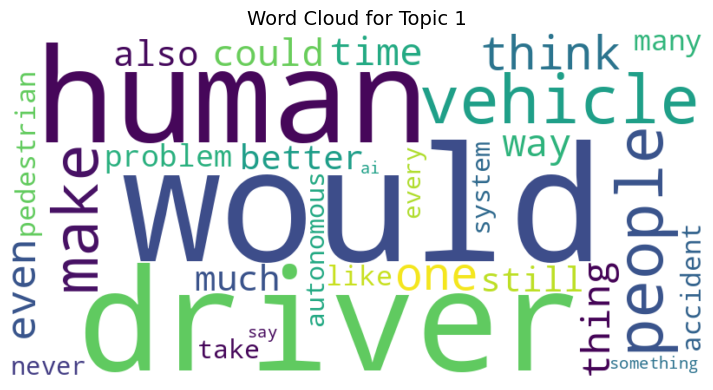

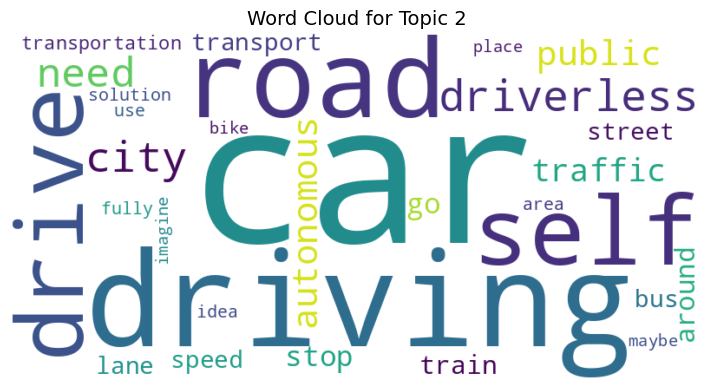

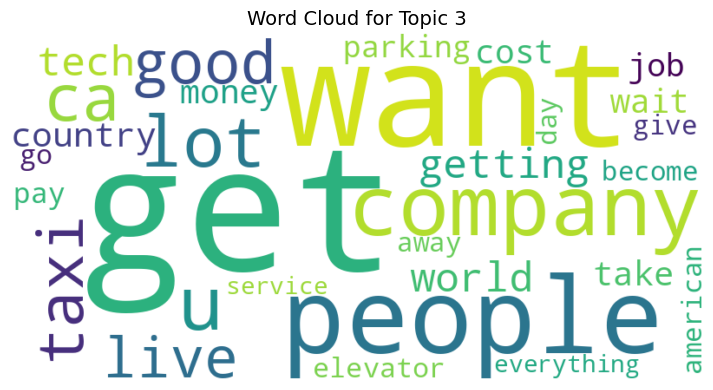

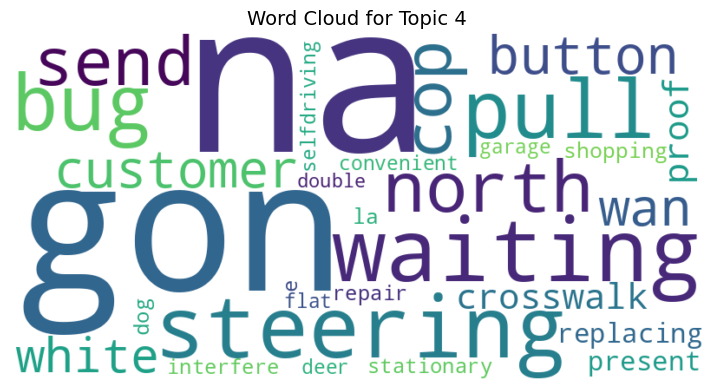

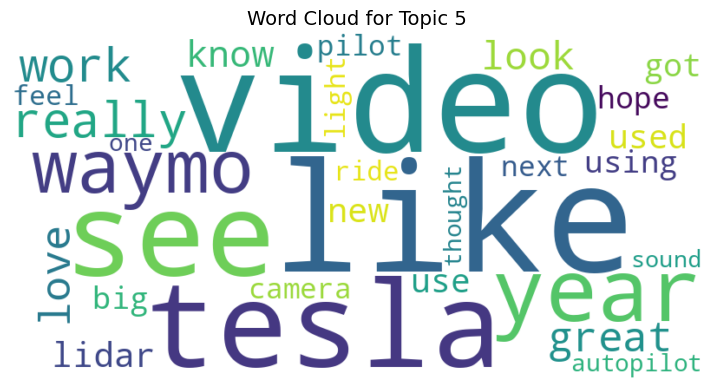

✅ Interactive LDA visualization saved to: lda_topic_visualization.html


In [ ]:
# Download NLTK data
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# Load Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords

df = pd.read_csv("comments_with_bert_sentiment.csv")
df = df.dropna(subset=['Sentiment', 'Cleaned_Comment'])
df = df[df['Sentiment'].str.strip() != '']
df = df[df['Cleaned_Comment'].str.strip() != '']


# Sentiment Distribution
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(7, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')
plt.title("Sentiment Distribution (BERT)", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.axis('equal')
plt.title("Sentiment Distribution (BERT) – Pie Chart", fontsize=14)
plt.show()

# Word Clouds by Sentiment
stop_words = set(stopwords.words('english'))

def generate_wordcloud(df_subset, sentiment_label):
    text = " ".join(comment for comment in df_subset['Cleaned_Comment'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words, colormap='Set2').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - {sentiment_label.capitalize()} Comments")
    plt.tight_layout()
    plt.show()

for sentiment in ['positive', 'neutral', 'negative']:
    generate_wordcloud(df[df['Sentiment'] == sentiment], sentiment)


# LDA Topic Modeling

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from gensim import corpora, models
import pyLDAvis.gensim_models
import pyLDAvis

tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()

def tokenize_lemmatize(text):
    tokens = tokenizer.tokenize(str(text).lower())
    return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

df["tokens"] = df["Cleaned_Comment"].apply(tokenize_lemmatize)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

# Build LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print top terms per topic
print("\nTop Keywords per Topic:")
for idx, topic in lda_model.print_topics(num_words=6):
    print(f"Topic {idx + 1}: {topic}")

# Word Cloud for each topic
for topic_id in range(lda_model.num_topics):
    plt.figure(figsize=(8, 4))
    plt.title(f"Word Cloud for Topic {topic_id+1}", fontsize=14)
    topic_words = dict(lda_model.show_topic(topic_id, topn=30))
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# LDA interactive visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_topic_visualization.html')
print("✅ Interactive LDA visualization saved to: lda_topic_visualization.html")


/tmp/ipython-input-10-3532774236.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index + 1, y=topic_counts.values, palette='Set3')


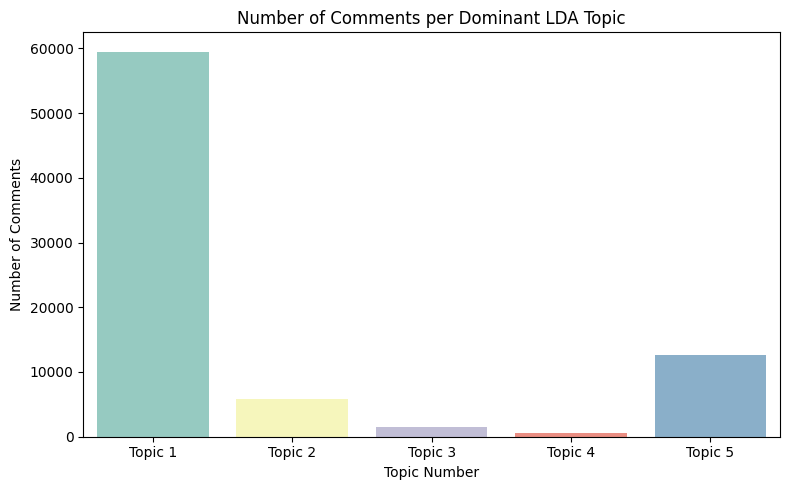

<Figure size 1000x600 with 0 Axes>

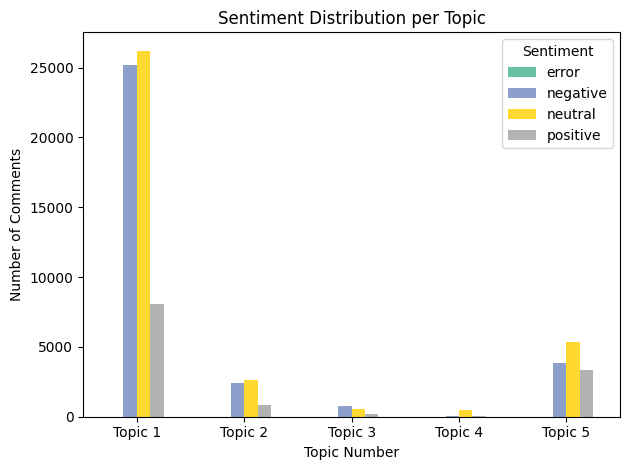

<Figure size 1000x600 with 0 Axes>

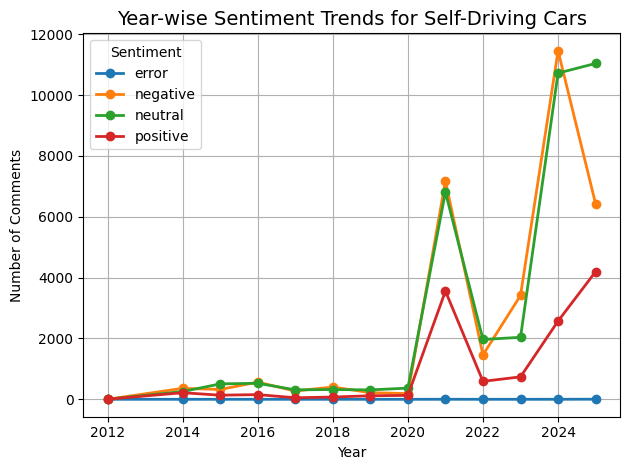

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from datetime import datetime

# Assign Dominant Topic to Each Comment
dominant_topics = []
for i, row in enumerate(corpus):
    topic_probs = lda_model.get_document_topics(row)
    if topic_probs:
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    else:
        dominant_topics.append(None)

df['Dominant_Topic'] = dominant_topics

# Topic Distribution Bar Chart
plt.figure(figsize=(8, 5))
topic_counts = df['Dominant_Topic'].value_counts().sort_index()
sns.barplot(x=topic_counts.index + 1, y=topic_counts.values, palette='Set3')
plt.xlabel("Topic Number")
plt.ylabel("Number of Comments")
plt.title("Number of Comments per Dominant LDA Topic")
plt.xticks(ticks=range(len(topic_counts)), labels=[f"Topic {i+1}" for i in topic_counts.index])
plt.tight_layout()
plt.show()

# Sentiment Breakdown per Topic
plt.figure(figsize=(10, 6))
sentiment_topic_counts = df.groupby(['Dominant_Topic', 'Sentiment']).size().unstack().fillna(0)
sentiment_topic_counts.plot(kind='bar', stacked=False, colormap='Set2')
plt.xlabel("Topic Number")
plt.ylabel("Number of Comments")
plt.title("Sentiment Distribution per Topic")
plt.xticks(ticks=range(len(sentiment_topic_counts)), labels=[f"Topic {i+1}" for i in sentiment_topic_counts.index], rotation=0)
plt.tight_layout()
plt.show()

# Year-wise Sentiment Trends (using column 'C')

# Rename and convert column 'C' to datetime
df.rename(columns={'C': 'Published At'}, inplace=True)
df['Published At'] = pd.to_datetime(df['Published At'], errors='coerce')
df = df.dropna(subset=['Published At'])
df['Year'] = df['Published At'].dt.year

# Group by Year and Sentiment
sentiment_yearly = df.groupby(['Year', 'Sentiment']).size().unstack().fillna(0)

# Plot the line chart
plt.figure(figsize=(10, 6))
sentiment_yearly.plot(kind='line', marker='o', linewidth=2)
plt.title("Year-wise Sentiment Trends for Self-Driving Cars", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Show topic keywords clearly
for i, topic in enumerate(lda_model.show_topics(num_topics=5, num_words=10), start=1):
    print(f"\nTopic {i} — Top Words:\n")
    words = topic[1].split(" + ")
    for w in words:
        print("-", w.split("*")[1].replace('"', ''))


Topic 1 — Top Words:

- would
- driver
- human
- vehicle
- people
- make
- think
- one
- even
- thing

Topic 2 — Top Words:

- car
- driving
- road
- self
- drive
- driverless
- city
- need
- autonomous
- public

Topic 3 — Top Words:

- get
- want
- people
- company
- u
- lot
- ca
- taxi
- good
- live

Topic 4 — Top Words:

- na
- gon
- waiting
- steering
- pull
- bug
- north
- send
- cop
- button

Topic 5 — Top Words:

- like
- video
- tesla
- see
- year
- waymo
- really
- work
- love
- great


Topic 1: Human Decision-Making vs. Machine Autonomy
Keywords like "would", "human", "make", "think", "even", and "thing" suggest philosophical/ethical concerns and public reflections about AI replacing human judgment in vehicles.

Topic 2: Infrastructure and Practicality of Driverless Cars
Keywords like "car", "driving", "road", "city", "autonomous", "public" reflect discussion around urban planning, road readiness, and integration of self-driving cars into daily transit.

Topic 3: User Demand and Service Expectations
With words like "get", "want", "company", "taxi", "live", "lot", this topic represents consumer interest, expectations for services (e.g., autonomous taxis), and how companies are responding.

Topic 4: Frustrations with Technical Bugs and Safety Concerns
Words like "bug", "steering", "pull", "cop", "button" point to real-world problems, system malfunctions, or fears based on technical failures and unpredictability.

Topic 5: Media, Branding & Public Excitement
Words like "video", "tesla", "waymo", "love", "great", "see" show positive sentiment, brand-specific enthusiasm, and reactions to AV content on platforms like YouTube.

In [ ]:
# Print sentiment distribution counts
print("Sentiment distribution:")
print(df['Sentiment'].value_counts())
print("\nSentiment percentages:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

Sentiment distribution:
Sentiment
neutral     35187
negative    32265
positive    12533
error           5
Name: count, dtype: int64

Sentiment percentages:
Sentiment
neutral     43.989249
negative    40.336292
positive    15.668209
error        0.006251
Name: proportion, dtype: float64
